# Reconhecimento de Padrões (TIP8311) - Trabalho 3


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 535049

In [13]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


In [14]:
data_path = "wall+following+robot+navigation+data/sensor_readings_24.data"

## Questão 01

Para este trabalho computacional, considere o conjunto de dados disponível no site abaixo.

Usando o conjunto original para 24 sensores de ultrassom. Pede-se:

1.1. Identificar para o problema em questão o número de classes, o númeor de instâncias/exemplos de cada classe e a dimensão do vetor de atributos.

1.2. Verificar se as matrizes de covariância das classes são invertíveis ou não.

1.3. Implementar e avaliar os seguintes classificadors: (1) classificador quadrático gaussiano (CQG) e (2) classificador de distância mímina ao protótipo¹ (DMP). Preencher a tabela abaixo após Nr = 100 Rodadas de treinamento/teste. Comente os resultados obtidos.



| Classificador | Média ± Desvio Padrão (Global) | Média ± Desvio Padrão (Classe 1) | Média ± Desvio Padrão (Classe 2) | Média ± Desvio Padrão (Classe 3) | Média ± Desvio Padrão (Classe 4) |
|---------------|--------------------------------|----------------------------------|----------------------------------|----------------------------------|----------------------------------|
| CQG           |                                |                                  |                                  |                                  |                                  |
| DMP           |                                |                                  |                                  |                                  |                                  |


In [ ]:
df = pd.read_csv(filepath_or_buffer=data_path, header=None)

In [3]:
data = np.genfromtxt(fname=data_path, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

y = y.reshape(-1, 1)

# X, y
X.shape

(5456, 24)

In [4]:
class CQG:
    def __init__(self, reg=1e-8):
        self.C = None         # classes
        self.mcov = None      # dict: classe -> matriz de covariância (p x p)
        self.means = None     # dict: classe -> vetor média (p x 1)
        self.priors = None    # dict: classe -> prior f(ωi)
        self.reg = reg        # regularização para estabilidade numérica

    def _mcov(self, X_i):
        # X_i: shape (p, N) -> p = nº features, N = nº amostras
        p, N = X_i.shape
        m = X_i.mean(axis=1).reshape(-1,1)
        R = (X_i @ X_i.T) / N
        C = R - (m @ m.T)
        return C

    def fit(self, X, y):
        """
        Treina o modelo.
        X: (n_samples, n_features)
        y: (n_samples, 1) ou (n_samples,)
        """
        y_flat = y.ravel()
        self.C = np.sort(np.unique(y_flat))
        self.mcov = {}
        self.means = {}
        self.priors = {}

        n = X.shape[0]
        for c in self.C:
            idx = np.where(y_flat == c)[0]
            Xc = X[idx]                 # shape (Nc, p)
            Nc = Xc.shape[0]
            if Nc == 0:
                raise ValueError(f"Classe {c} sem amostras.")

            # média como vetor coluna (p,1)
            mean_c = Xc.mean(axis=0).reshape(-1,1)

            # covariância usando _mcov (espera p x N)
            cov_c = self._mcov(Xc.T)

            # regularização na diagonal para evitar singularidade
            cov_c = cov_c + self.reg * np.eye(cov_c.shape[0])

            prior_c = Nc / n

            self.means[c] = mean_c
            self.mcov[c] = cov_c
            self.priors[c] = prior_c

    def _Qi(self, x_col, mean_col, inv_cov):
        """
        Calcula Q_i(x) = (x - m_i)^T C_i^{-1} (x - m_i)
        x_col, mean_col: (p,1)
        inv_cov: (p,p)
        retorna escalar
        """
        diff = x_col - mean_col
        return diff.T @ inv_cov @ diff

    def predict(self, X):
        """
        Prediz rótulos para X (n_samples, n_features).
        Retorna array com rótulos (mesmo tipo de self.C).
        """
        if self.C is None:
            raise ValueError("Modelo não treinado. Chame fit(X, y) primeiro.")

        n, p = X.shape
        preds = np.empty(n, dtype=self.C.dtype)

        # pré-computar inversas e log-determinantes por classe
        invs = {}
        logdets = {}
        for c in self.C:
            cov = self.mcov[c]
            # usar slogdet para estabilidade
            sign, logdet = np.linalg.slogdet(cov)
            if sign <= 0:
                # fallback (deveria ser raro por causa da regularização)
                logdet = np.log(np.linalg.det(cov) + 1e-20)
            invs[c] = np.linalg.inv(cov)
            logdets[c] = logdet

        for i in range(n):
            x_col = X[i].reshape(-1,1)
            best_c = None
            best_g = np.inf  # queremos o menor g_i^*(x)
            for c in self.C:
                inv_cov = invs[c]
                Qi = self._Qi(x_col, self.means[c], inv_cov)
                # g*_i(x) = Qi(x) + ln(|Ci|) - 2 ln(f(ωi))
                prior = self.priors[c]
                # evitar log(0)
                if prior <= 0:
                    raise ValueError(f"Prior da classe {c} é zero.")
                g = Qi + logdets[c] - 2.0 * np.log(prior)
                if g < best_g:
                    best_g = g
                    best_c = c
            preds[i] = best_c

        return preds


In [15]:
class CQG:
    def __init__(self, reg=1e-8):
        self.reg = float(reg)
        self.classes_ = None
        self.means_ = {}
        self.priors_ = {}
        self.inv_covs_ = {}
        self.logdets_ = {}

    def _mcov(self, X_i):
        """
        Calcula a matriz de covariância manualmente.
        X_i: shape (p, N) -> p = nº features, N = nº amostras
        """
        p, N = X_i.shape
        m = X_i.mean(axis=1).reshape(-1, 1)
        R = (X_i @ X_i.T) / N
        C = R - (m @ m.T)
        return C

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).ravel()
        
        self.classes_ = np.sort(np.unique(y))
        n_samples = X.shape[0]

        for c in self.classes_:
            Xc = X[y == c]
            Nc = len(Xc)

            # 1. Priori e Médias (média armazenada como 1D para o predict vetorizado)
            self.priors_[c] = Nc / n_samples
            self.means_[c] = Xc.mean(axis=0)

            # 2. Covariância usando o seu método manual (passando Xc transposto)
            cov_c = self._mcov(Xc.T)
            
            # 3. Regularização para estabilidade numérica
            cov_c += self.reg * np.eye(cov_c.shape[0])

            # 4. Pré-computar inversa e log-determinante no momento do TREINO
            sign, logdet = np.linalg.slogdet(cov_c)
            self.logdets_[c] = logdet
            self.inv_covs_[c] = np.linalg.inv(cov_c)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        
        # Matriz para armazenar o score g_i(x) de cada amostra para cada classe
        scores = np.zeros((n_samples, len(self.classes_)))

        for idx, c in enumerate(self.classes_):
            # Diferença vetorizada: amostras - média da classe C
            diff = X - self.means_[c] 
            
            # Cálculo vetorizado de Q_i(x) = (x - m)^T C^{-1} (x - m)
            Qi = np.sum((diff @ self.inv_covs_[c]) * diff, axis=1)
            
            # Função discriminante: g*_i(x) = Q_i(x) + ln(|C_i|) - 2 ln(P(w_i))
            scores[:, idx] = Qi + self.logdets_[c] - 2.0 * np.log(self.priors_[c])

        # A classe predita é a que possui o MENOR score g_i(x)
        best_class_idx = np.argmin(scores, axis=1)
        return self.classes_[best_class_idx]

In [86]:
class Kmeans:
    """K-means sequencial (online) com alpha = 1 / count_i(t) e kmeans++."""

    def __init__(self, k=3, max_epochs=100, tol=1e-4, random_state=None,
                 init='random', handle_empty='reinit'):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)
        self.random_state = random_state
        self.init = init
        self.handle_empty = handle_empty

        self.centroids = None
        self.counts = None
        self.inertia_ = None
        self.n_iter_ = 0
        self.rng = np.random.default_rng(random_state)

    def _check_X(self, X):
        if not isinstance(X, np.ndarray):
            X = np.asarray(X, dtype=float)
        else:
            X = X.astype(float, copy=False)
        if X.ndim != 2:
            raise ValueError("X deve ser 2D com shape (n_samples, n_features).")
        if np.isnan(X).any():
            raise ValueError("X contém NaNs. Trate-os antes de ajustar.")
        return X

    def _init_centroids(self, X):
        n, _ = X.shape
        if self.k > n:
            raise ValueError("k não pode ser maior que o número de amostras.")

        if self.init == 'random':
            idx = self.rng.choice(n, size=self.k, replace=False)
            self.centroids = X[idx].astype(float).copy()
        elif self.init == 'kmeans++':
            # kmeans++ initialization
            centroids = np.empty((self.k, X.shape[1]), dtype=float)
            # 1) choose first centroid uniformly at random
            first_idx = int(self.rng.integers(0, n))
            centroids[0] = X[first_idx]
            # 2) choose remaining centroids
            # distances squared to nearest chosen centroid
            closest_dist_sq = np.sum((X - centroids[0])**2, axis=1)
            for c in range(1, self.k):
                # probability proportional to distance squared
                total = closest_dist_sq.sum()
                if total == 0.0:
                    # all points identical to chosen centroids; pick random remaining
                    next_idx = int(self.rng.integers(0, n))
                else:
                    probs = closest_dist_sq / total
                    next_idx = int(self.rng.choice(n, p=probs))
                centroids[c] = X[next_idx]
                # update closest distances squared
                dist_to_new = np.sum((X - centroids[c])**2, axis=1)
                closest_dist_sq = np.minimum(closest_dist_sq, dist_to_new)
            self.centroids = centroids
        else:
            # fallback para random
            idx = self.rng.choice(n, size=self.k, replace=False)
            self.centroids = X[idx].astype(float).copy()

        self.counts = np.zeros(self.k, dtype=int)

    def _handle_empty_clusters(self, X, labels):
        for i in range(self.k):
            if np.sum(labels == i) == 0:
                if self.handle_empty == 'reinit':
                    self.centroids[i] = X[self.rng.integers(0, X.shape[0])]
                    self.counts[i] = 0
                elif self.handle_empty == 'farthest':
                    dists = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
                    far_idx = np.argmax(np.min(dists, axis=1))
                    self.centroids[i] = X[far_idx]
                    self.counts[i] = 0

    def predict(self, X):
        if self.centroids is None:
            raise RuntimeError("Modelo não treinado. Chame fit(X) primeiro.")
        X = self._check_X(X)
        dists = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(dists, axis=1)

    def fit(self, X):
        X = self._check_X(X)
        n, _ = X.shape
        self._init_centroids(X)
        prev_centroids = self.centroids.copy()

        for epoch in range(1, self.max_epochs + 1):
            perm = self.rng.permutation(n)
            X_shuffled = X[perm]

            for x in X_shuffled:
                dists = np.linalg.norm(self.centroids - x, axis=1)
                i_star = int(np.argmin(dists))
                self.counts[i_star] += 1
                alpha = 1.0 / self.counts[i_star]
                self.centroids[i_star] = (1 - alpha) * self.centroids[i_star] + alpha * x

            labels = self.predict(X)
            self._handle_empty_clusters(X, labels)

            shift = np.linalg.norm(self.centroids - prev_centroids)
            prev_centroids = self.centroids.copy()
            self.n_iter_ = epoch

            dists = np.linalg.norm(X - self.centroids[labels], axis=1)
            self.inertia_ = float(np.sum(dists ** 2))

            if shift < self.tol:
                break

        return self


In [ ]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = k
        self.max_epochs = max_epochs
        self.tol = float(tol)
        
        self.centroids = None
        self.counts = None
        self.n_iter_ = 0
        self.labels_ = None
        self.inertia_ = None
        self.cluster_centers_ = None
    

    def fit(self, X):
        n = len(X)

        self._init_centroids(X)

        SSD = []
        prev_controids = None

        for r in range(self.max_epochs):

            dmin, icluster = [], []

            for t in range(n):
                dist = []
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist.append(sum((diff)**2))

                dmin.append(np.min(dist))
                # dmin = np.array(dmin)
                icluster.append(np.argmin(dist))
                # icluster = np.array(icluster)

            SSD.append(np.sum(dmin))

            particao = []
            for k_ in range(self.k):
                mask_i = (icluster == k_)
                particao.append(X[mask_i, :])
                self.centroids[k_, :] = np.mean(particao[k_], axis=0)

            for t in range(n):
                dist = []
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist.append(sum(abs(diff)**2))
                dist = np.array(dist)
                dummy = np.min(dist)
                icluster[t] = np.argmin(dist)

            if prev_controids is not None:
                shift = np.linalg.norm(self.centroids - prev_controids, axis=1)
                if np.max(shift) < self.tol:
                    self.n_iter = r + 1
                    self.labels_ = icluster
                    self.inertia_ = SSD[-1]
                    self.cluster_centers_ = self.centroids.copy()
                    return self
                
            prev_controids = self.centroids.copy()

        self.n_iter_ = self.n_iter_ or self.max_epochs
        self.labels_ = icluster
        self.inertia_ = SSD[-1] if SSD else 0.0
        self.cluster_centers_ = self.centroids.copy()
        return self  

    def _init_centroids(self, X):
        n = len(X)
        idx = np.random.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].astype(float)

In [ ]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)

        self.centroids = None
        self.centroids_labels = None
        self.counts = None
        self.n_iter_ = 0
        self.labels_ = None
        self.inertia_ = None
        self.cluster_centers_ = None

    def fit(self, X):
        X = np.asarray(X)
        n, m = X.shape

        self._init_centroids(X)

        SSD = []
        prev_centroids = None

        for r in range(self.max_epochs):
            # Atribuição: calcular distâncias e rótulos
            dmin = np.empty(n, dtype=float)
            icluster = np.empty(n, dtype=int)

            for t in range(n):
                dist = np.empty(self.k, dtype=float)
                for k_ in range(self.k):
                    diff = X[t, :] - self.centroids[k_, :]
                    dist[k_] = np.sum(diff**2)   # distância ao quadrado
                dmin[t] = np.min(dist)
                icluster[t] = np.argmin(dist)

            SSD.append(np.sum(dmin))  # dmin já é distância ao quadrado

            # Atualização dos centróides
            for k_ in range(self.k):
                mask_i = (icluster == k_)
                if np.any(mask_i):
                    self.centroids[k_, :] = np.mean(X[mask_i, :], axis=0)
                else:
                    # Partição vazia: manter centróide anterior (mínima alteração)
                    # alternativa: re-inicializar com ponto aleatório
                    pass

            # Critério de parada por convergência dos centróides
            if prev_centroids is not None:
                shift = np.linalg.norm(self.centroids - prev_centroids, axis=1)
                if np.max(shift) < self.tol:
                    self.n_iter_ = r + 1
                    self.labels_ = icluster
                    self.inertia_ = SSD[-1]
                    self.cluster_centers_ = self.centroids.copy()
                    return self

            prev_centroids = self.centroids.copy()

        # Finalização após max_epochs
        self.n_iter_ = self.n_iter_ or self.max_epochs
        self.labels_ = icluster
        self.inertia_ = SSD[-1] if SSD else 0.0
        self.cluster_centers_ = self.centroids.copy()
        return self

    def predict(self, X):
        n = len(X)
        k = len(self.centroids)

        label_pred = []
        
        for i in range(n):
            dist = []
            for j in range(k):
                diff = X[i, :] - self.centroids[j, :]
                dist.append(np.sum(diff ** 2))

            idx = np.argmin(dist)
            label_pred.append(self.centroids_labels[idx])

        return np.array(label_pred).reshape(-1, 1)

    def _init_centroids(self, X):
        n = X.shape[0]
        if self.k > n:
            raise ValueError("k must be <= number of samples")
        idx = np.random.choice(n, size=self.k, replace=False)
        self.centroids = X[idx].astype(float)


In [16]:
class Kmeans:
    def __init__(self, k=3, max_epochs=100, tol=1e-4):
        self.k = int(k)
        self.max_epochs = int(max_epochs)
        self.tol = float(tol)
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]

        # Inicialização simples (aleatória)
        idx = np.random.choice(n_samples, size=self.k, replace=False)
        self.centroids = X[idx].copy()

        for _ in range(self.max_epochs):
            # 1. Cálculo de distâncias (Vetorizado: N amostras x K centróides)
            # Cria uma matriz de distâncias onde dists[i, j] é a dist da amostra i ao centróide j
            dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
            
            # 2. Atribuição de clusters (menor distância)
            new_labels = np.argmin(dists, axis=1)
            
            # Cálculo da inércia (soma das distâncias mínimas ao quadrado)
            self.inertia_ = np.sum(np.min(dists, axis=1))

            # 3. Atualização dos centróides
            new_centroids = np.zeros_like(self.centroids)
            for k in range(self.k):
                mask = (new_labels == k)
                if np.any(mask):
                    new_centroids[k] = np.mean(X[mask], axis=0)
                else:
                    # Se cluster vazio, mantém o antigo para estabilidade
                    new_centroids[k] = self.centroids[k]

            # 4. Critério de parada
            shift = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            self.labels_ = new_labels

            if shift < self.tol:
                break
        
        return self

    def predict(self, X):
        # Calcula distâncias para os centróides aprendidos e retorna o índice do mais próximo
        dists = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) ** 2
        return np.argmin(dists, axis=1)

# Exemplo de uso
# model = Kmeans(k=3)
# model.fit(X)
# clusters = model.predict(X)

In [17]:
def davies_bouldin_score(X, labels, centroids, q=2, t=2):
    k = len(centroids)
    # O índice DB avalia a separação entre clusters, logo, não faz sentido para K=1.
    if k < 2:
        return float('inf') 

    # Equação 27: Calcular a dispersão intra-grupo S_i
    S = np.zeros(k)
    for i in range(k):
        mask = (labels == i)
        N_i = np.sum(mask)
        if N_i > 0:
            diffs = np.abs(X[mask] - centroids[i])
            # Soma de ||x - w_i||^q
            dist_q = np.sum(diffs ** q, axis=1) 
            S[i] = (np.sum(dist_q) / N_i) ** (1 / q)
        else:
            S[i] = 0.0 # Cluster vazio

    # Equações 25 e 26: Calcular o índice DB
    db_index = 0.0
    for i in range(k):
        max_R = -np.inf
        for j in range(k):
            if i != j:
                # Equação 28: Distância de Minkowski de ordem t entre centróides
                d_ij = np.sum(np.abs(centroids[i] - centroids[j]) ** t) ** (1 / t)
                
                # Equação 26: Razão R_{i,qt}
                if d_ij == 0:
                    R_ij = 0.0 # Evita divisão por zero se centróides colidirem
                else:
                    R_ij = (S[i] + S[j]) / d_ij
                    
                if R_ij > max_R:
                    max_R = R_ij
                    
        db_index += max_R
        
    return db_index / k

In [18]:
class DMP:
    def __init__(self, k_min=2, k_max=5, n_runs=5, max_epochs=100, q=2, t=2):
        self.k_min = int(k_min)
        self.k_max = int(k_max)
        self.n_runs = int(n_runs)
        self.max_epochs = int(max_epochs)
        self.q = int(q)
        self.t = int(t)
        
        self.prototypes_ = None
        self.labels_ = None
        self.k_opt_ = {} # Dicionário para guardarmos o K ótimo de cada classe

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        
        # Passo 1: Separar as instâncias
        classes = np.unique(y)
        
        all_prototypes = []
        all_labels = []
        
        # Passo 7: Repetir para cada classe
        for c in classes:
            X_c = X[y == c]
            n_samples = len(X_c)
            
            # Garante que não vamos procurar um K maior que a quantidade de dados da classe
            k_max_c = min(self.k_max, n_samples)
            k_min_c = min(self.k_min, n_samples)
            
            # Se a classe tiver apenas 1 amostra, K_opt é forçosamente 1
            if k_max_c < 2:
                self.k_opt_[c] = 1
                all_prototypes.append(X_c)
                all_labels.extend([c])
                continue

            best_k_overall = k_min_c
            min_db_score = float('inf')
            best_centroids_overall = None
            
            # Passo 5: Varrer de K_min até K_max para achar o K_opt
            for k in range(k_min_c, k_max_c + 1):
                best_inertia = float('inf')
                best_centroids = None
                best_labels = None
                
                # Passo 2: Aplicar K-médias por Nr rodadas
                for _ in range(self.n_runs):
                    kmeans = Kmeans(k=k, max_epochs=self.max_epochs)
                    kmeans.fit(X_c)
                    
                    # Passo 3: Escolher a rodada com menor SSD (Inércia)
                    if kmeans.inertia_ < best_inertia:
                        best_inertia = kmeans.inertia_
                        best_centroids = kmeans.centroids.copy()
                        best_labels = kmeans.labels_.copy()
                        
                # Passo 4: Calcular o índice de validação DB para o melhor K-médias deste 'k'
                db_score = davies_bouldin_score(X_c, best_labels, best_centroids, q=self.q, t=self.t)
                
                # Passo 5: Atualizar se encontrarmos um DB menor (partição mais válida)
                if db_score < min_db_score:
                    min_db_score = db_score
                    best_k_overall = k
                    best_centroids_overall = best_centroids.copy()
            
            # Passo 6: Armazenar os protótipos ótimos da classe
            self.k_opt_[c] = best_k_overall
            all_prototypes.append(best_centroids_overall)
            all_labels.extend([c] * best_k_overall)
            
        # Passo 1 (Classificação): Concatenar a matriz W e os rótulos
        self.prototypes_ = np.vstack(all_prototypes)
        self.labels_ = np.array(all_labels)
        
        return self

    def predict(self, X):
        X = np.asarray(X)
        dists = np.linalg.norm(X[:, np.newaxis] - self.prototypes_, axis=2) ** 2
        nearest_idx = np.argmin(dists, axis=1)
        return self.labels_[nearest_idx].reshape(-1, 1)

In [19]:
class PCA:
    def __init__(self, n_components=None, whiten=False):
        self.n_components = n_components
        self.whiten = bool(whiten)

        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        n, p = X.shape
        
        # 1. Centralizando os dados
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2. Decomposição SVD (Singular Value Decomposition)
        # Xc = U * S * Vt
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        
        # 3. Cálculo dos autovalores (variância) e autovetores (componentes)
        vals = (S ** 2) / (n - 1)
        vecs = Vt.T

        # 4. Seleção da quantidade de componentes (q)
        q = self.n_components if self.n_components is not None else min(n, p)

        self.components_ = vecs[:, :q].T  # Shape final: (q, p)
        self.explained_variance_ = vals[:q]
        
        total_var = vals.sum()
        self.explained_variance_ratio_ = (vals[:q] / total_var) if total_var > 0 else np.zeros(q)

        # 5. Aplicação do branqueamento (opcional)
        if self.whiten:
            eps = 1e-12 # Constante de estabilidade para evitar divisão por zero
            self.components_ = self.components_ / np.sqrt(self.explained_variance_[:, None] + eps)

        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        return np.dot(Xc, self.components_.T)

    def inverse_transform(self, Z):
        Z = np.asarray(Z, dtype=float)
        Xc_rec = np.dot(Z, self.components_)
        return Xc_rec + self.mean_

In [ ]:
def make_bubbles(n_samples=500, centers=4, cluster_std=None, random_state=0):
    """
    Gera um dataset tipo 'bubbles' usando make_blobs.
    - n_samples: total de pontos
    - centers: número de centros (int ou array de coordenadas)
    - cluster_std: escalar ou lista com std por centro (ex: [0.3, 0.6, 1.0, 0.4])
    - random_state: semente para reprodutibilidade
    Retorna: X (n_samples, 2), y (rótulos)
    """
    X, y = make_blobs(n_samples=n_samples,
                      centers=centers,
                      cluster_std=cluster_std,
                      random_state=random_state)
    return X, y

if __name__ == "__main__":
    # Exemplo: 4 bolhas com tamanhos diferentes
    np.random.seed(0)
    centers = 4
    stds = [0.25, 0.6, 1.0, 0.35]   # bolhas de tamanhos variados
    X, y = make_bubbles(n_samples=200, centers=centers, cluster_std=stds, random_state=42)

    # Plot básico
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=30, edgecolor='k', alpha=0.8)
    plt.title("Dataset sintético tipo 'bubbles' (make_blobs)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()


## Questão 01

Para este trabalho computacional, considere o conjunto de dados disponível no site abaixo.

Usando o conjunto original para 24 sensores de ultrassom. Pede-se:

1.1. Identificar para o problema em questão o número de classes, o númeor de instâncias/exemplos de cada classe e a dimensão do vetor de atributos.

1.2. Verificar se as matrizes de covariância das classes são invertíveis ou não.

1.3. Implementar e avaliar os seguintes classificadors: (1) classificador quadrático gaussiano (CQG) e (2) classificador de distância mímina ao protótipo¹ (DMP). Preencher a tabela abaixo após Nr = 100 Rodadas de treinamento/teste. Comente os resultados obtidos.



In [20]:
data = np.genfromtxt(fname=data_path, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

# y = y.reshape(-1, 1)

In [21]:
classes, counts = np.unique(y, return_counts=True)
n_amostras, p = X.shape

print(f"Dimensão do vetor de atributos (p): {p}")
print(f"Número de classes: {len(classes)}")
for c, count in zip(classes, counts):
    print(f" -> Classe {c}: {count} instâncias")
print("-" * 40 + "\n")

Dimensão do vetor de atributos (p): 24
Número de classes: 4
 -> Classe Move-Forward: 2205 instâncias
 -> Classe Sharp-Right-Turn: 2097 instâncias
 -> Classe Slight-Left-Turn: 328 instâncias
 -> Classe Slight-Right-Turn: 826 instâncias
----------------------------------------



In [22]:
for c in classes:
    Xc = X[y == c]
    cov = np.cov(Xc, rowvar=False)
    det = np.linalg.det(cov)
    posto = np.linalg.matrix_rank(cov)
    
    # Uma matriz é invertível se seu determinante é != 0 (ou posto == p)
    if np.isclose(det, 0.0):
        status = "NÃO INVERTÍVEL (Singular)"
    else:
        status = "INVERTÍVEL"
        
    print(f"Classe {c}: {status} | Determinante = {det:.2e} | Posto = {posto}/{X.shape[1]}")
print("-" * 40 + "\n")

Classe Move-Forward: INVERTÍVEL | Determinante = 2.56e-01 | Posto = 24/24
Classe Sharp-Right-Turn: INVERTÍVEL | Determinante = 1.23e+01 | Posto = 24/24
Classe Slight-Left-Turn: NÃO INVERTÍVEL (Singular) | Determinante = 3.61e-11 | Posto = 24/24
Classe Slight-Right-Turn: INVERTÍVEL | Determinante = 4.64e-07 | Posto = 24/24
----------------------------------------



In [23]:
def calcular_acuracias(y_true, y_pred, classes):
    """Calcula a acurácia global e por classe"""
    accs = {}
    accs['Global'] = np.mean(y_true == y_pred)
    for c in classes:
        mask = (y_true == c)
        if np.sum(mask) > 0:
            accs[c] = np.mean(y_true[mask] == y_pred[mask])
        else:
            accs[c] = 0.0
    return accs

In [98]:
def executar_experimento(X, y, classes, nr_rodadas=100, q_pca=None):
    """Roda as 100 iterações de treino/teste e calcula as estatísticas (Questões 1.3 e 2.2)"""
    n_amostras = X.shape[0]
    
    # Dicionários para armazenar históricos de acurácia
    hist_cqg = {'Global': [], **{c: [] for c in classes}}
    hist_dmp = {'Global': [], **{c: [] for c in classes}}
    
    print(f"Iniciando {nr_rodadas} rodadas... (Isso pode levar alguns instantes)")
    
    for rodada in tqdm(range(nr_rodadas)):
        # 1. Embaralhar e dividir dados (80% treino, 20% teste)
        idx = np.random.permutation(n_amostras)
        limite = int(0.8 * n_amostras)
        idx_treino, idx_teste = idx[:limite], idx[limite:]
        
        X_treino, X_teste = X[idx_treino], X[idx_teste]
        y_treino, y_teste = y[idx_treino], y[idx_teste]
        
        # 2. Aplicação do PCA (Se especificado - Questão 2.2)
        if q_pca is not None:
            pca = PCA(n_components=q_pca, whiten=True)
            pca.fit(X_treino)
            X_treino = pca.transform(X_treino)
            X_teste = pca.transform(X_teste)
        
        # 3. Treinar e Testar CQG
        cqg = CQG(reg=1e-6) # Leve regularização para garantir estabilidade
        cqg.fit(X_treino, y_treino)
        preds_cqg = cqg.predict(X_teste)
        
        accs_cqg = calcular_acuracias(y_teste, preds_cqg, classes)
        for k, v in accs_cqg.items(): hist_cqg[k].append(v)
            
        # 4. Treinar e Testar DMP
        # Limitamos max_epochs e rodadas internas para o laço de 100 rodadas não demorar horas
        dmp = DMP(k_min=1, k_max=5, n_runs=3, max_epochs=50)
        dmp.fit(X_treino, y_treino)
        preds_dmp = dmp.predict(X_teste).ravel()
        
        accs_dmp = calcular_acuracias(y_teste, preds_dmp, classes)
        for k, v in accs_dmp.items(): hist_dmp[k].append(v)
            
    # Formatação da Tabela
    print("\n| Classificador | Média ± Desvio Padrão (Global) | " + " | ".join([f"Média ± DP (Classe {c})" for c in classes]) + " |")
    print("|---" * (len(classes) + 2) + "|")
    
    def formatar_linha(nome, hist):
        linha = f"| {nome} | {np.mean(hist['Global'])*100:.2f}% ± {np.std(hist['Global'])*100:.2f}% | "
        linha += " | ".join([f"{np.mean(hist[c])*100:.2f}% ± {np.std(hist[c])*100:.2f}%" for c in classes]) + " |"
        return linha
        
    print(formatar_linha("CQG", hist_cqg))
    print(formatar_linha("DMP", hist_dmp))
    print("\n")


print("=== RESULTADOS QUESTÃO 1.3 (SEM PCA) ===")
executar_experimento(X, y, classes, nr_rodadas=100, q_pca=None)

# Passo 4: Questão 2.2 (Com PCA)
# SUBSTITUA O VALOR DE Q ABAIXO PELO VALOR QUE VOCÊ ESCOLHEU OLHANDO O GRÁFICO
q_escolhido = 5
print(f"=== RESULTADOS QUESTÃO 2.2 (COM PCA, q={q_escolhido}) ===")
executar_experimento(X, y, classes, nr_rodadas=100, q_pca=q_escolhido)

=== RESULTADOS QUESTÃO 1.3 (SEM PCA) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.04% ± 1.25% | 63.13% ± 2.03% | 61.96% ± 2.32% | 89.19% ± 4.05% | 88.13% ± 2.61% |
| DMP | 63.59% ± 2.13% | 53.45% ± 5.30% | 65.03% ± 5.25% | 85.57% ± 5.77% | 78.25% ± 6.87% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=5) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 65.77% ± 1.34% | 54.78% ± 2.26% | 83.22% ± 1.61% | 87.69% ± 3.86% | 42.45% ± 3.92% |
| DMP | 60.62% ± 1.75% | 49.36% ± 3.74% | 64.88% ± 3.67% | 77.36% ± 6.65% | 73.22% ± 5.64% |




In [104]:
for q in [i for i in range(24,1,-1)]:
    q_escolhido = q
    print(f"=== RESULTADOS QUESTÃO 2.2 (COM PCA, q={q_escolhido}) ===")
    executar_experimento(X, y, classes, nr_rodadas=100, q_pca=q_escolhido)

=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=24) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.15% ± 1.44% | 62.98% ± 2.20% | 62.35% ± 2.54% | 89.18% ± 3.78% | 88.15% ± 2.28% |
| DMP | 61.35% ± 3.05% | 64.14% ± 10.22% | 56.25% ± 10.01% | 76.38% ± 9.25% | 60.83% ± 11.45% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=23) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.76% ± 1.67% | 63.20% ± 3.04% | 64.10% ± 2.26% | 89.31% ± 3.73% | 87.23% ± 3.33% |
| DMP | 61.42% ± 3.52% | 63.67% ± 10.24% | 57.27% ± 11.82% | 77.45% ± 11.11% | 59.82% ± 14.27% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=22) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.83% ± 1.56% | 61.63% ± 2.33% | 66.10% ± 2.73% | 88.16% ± 3.55% | 87.19% ± 3.10% |
| DMP | 60.57% ± 3.75% | 61.45% ± 11.25% | 56.90% ± 13.48% | 80.62% ± 9.56% | 59.29% ± 13.76% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=21) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:45<00:00,  1.06s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.85% ± 1.49% | 57.00% ± 2.52% | 68.06% ± 2.52% | 87.27% ± 3.63% | 88.62% ± 2.59% |
| DMP | 61.40% ± 2.82% | 56.95% ± 10.19% | 63.37% ± 8.74% | 82.40% ± 9.00% | 59.70% ± 15.29% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=20) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.99% ± 1.34% | 57.23% ± 2.22% | 68.38% ± 1.96% | 87.36% ± 4.03% | 88.11% ± 2.58% |
| DMP | 62.18% ± 3.03% | 59.47% ± 11.35% | 62.97% ± 8.58% | 81.82% ± 9.08% | 59.35% ± 15.33% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=19) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.75% ± 1.42% | 57.28% ± 2.20% | 67.63% ± 2.30% | 87.01% ± 4.32% | 88.68% ± 2.47% |
| DMP | 61.74% ± 3.32% | 57.78% ± 9.84% | 63.73% ± 8.45% | 83.30% ± 6.50% | 58.65% ± 15.58% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=18) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.74% ± 1.24% | 57.02% ± 2.11% | 68.02% ± 2.37% | 86.74% ± 3.81% | 88.20% ± 2.47% |
| DMP | 63.11% ± 2.34% | 60.69% ± 6.35% | 65.95% ± 7.77% | 81.08% ± 8.68% | 55.22% ± 15.45% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=17) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.22% ± 1.50% | 56.89% ± 2.34% | 66.94% ± 2.20% | 86.79% ± 4.00% | 87.86% ± 3.15% |
| DMP | 62.91% ± 2.55% | 61.22% ± 6.60% | 64.69% ± 7.31% | 79.51% ± 8.95% | 56.33% ± 15.59% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=16) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.39% ± 1.31% | 57.01% ± 1.94% | 67.03% ± 2.05% | 87.59% ± 3.39% | 87.89% ± 2.92% |
| DMP | 62.88% ± 2.71% | 60.78% ± 6.39% | 65.70% ± 7.56% | 80.44% ± 9.37% | 54.37% ± 16.52% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=15) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:06<00:00,  1.49it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.55% ± 1.38% | 57.73% ± 2.40% | 69.38% ± 2.37% | 87.19% ± 4.33% | 87.98% ± 2.81% |
| DMP | 63.65% ± 2.70% | 60.91% ± 6.75% | 67.43% ± 5.63% | 82.20% ± 8.16% | 53.66% ± 16.26% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=14) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 69.25% ± 1.37% | 58.32% ± 2.41% | 71.60% ± 2.29% | 86.28% ± 3.64% | 85.70% ± 3.18% |
| DMP | 63.55% ± 2.68% | 61.25% ± 5.88% | 67.76% ± 6.28% | 84.27% ± 7.40% | 50.88% ± 16.41% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=13) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 69.64% ± 1.30% | 58.38% ± 2.28% | 73.89% ± 2.08% | 86.02% ± 3.61% | 82.36% ± 3.07% |
| DMP | 63.07% ± 2.00% | 61.07% ± 5.59% | 67.33% ± 5.71% | 87.59% ± 5.24% | 47.92% ± 15.95% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=12) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 68.56% ± 1.63% | 57.27% ± 2.51% | 73.08% ± 2.17% | 87.13% ± 3.75% | 80.25% ± 3.04% |
| DMP | 63.14% ± 2.37% | 61.56% ± 5.52% | 66.79% ± 5.52% | 88.33% ± 6.61% | 47.95% ± 18.49% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=11) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 69.12% ± 1.25% | 58.36% ± 2.42% | 75.09% ± 1.94% | 87.03% ± 3.81% | 75.69% ± 3.18% |
| DMP | 63.16% ± 1.95% | 60.66% ± 5.40% | 67.42% ± 5.35% | 89.86% ± 4.31% | 48.57% ± 18.80% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=10) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.24% ± 1.30% | 54.74% ± 2.00% | 76.95% ± 1.68% | 84.27% ± 4.13% | 69.19% ± 3.75% |
| DMP | 62.29% ± 2.15% | 60.01% ± 5.40% | 65.90% ± 5.71% | 90.69% ± 4.05% | 47.78% ± 18.00% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=9) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 66.13% ± 1.42% | 51.96% ± 2.58% | 76.79% ± 1.89% | 87.44% ± 3.67% | 68.37% ± 3.48% |
| DMP | 60.98% ± 2.07% | 58.61% ± 6.26% | 65.77% ± 5.90% | 90.90% ± 3.74% | 43.22% ± 20.75% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=8) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [02:30<00:00,  1.51s/it]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 67.20% ± 1.21% | 53.61% ± 2.47% | 77.79% ± 2.28% | 86.98% ± 3.65% | 68.37% ± 3.78% |
| DMP | 58.37% ± 1.92% | 49.45% ± 4.24% | 53.39% ± 3.63% | 89.47% ± 5.61% | 82.09% ± 6.66% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=7) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 66.87% ± 1.41% | 54.59% ± 2.45% | 78.66% ± 1.93% | 86.46% ± 4.49% | 62.07% ± 3.61% |
| DMP | 60.01% ± 2.10% | 51.85% ± 2.52% | 57.74% ± 4.71% | 86.44% ± 7.98% | 76.88% ± 4.85% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=6) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 65.83% ± 1.36% | 55.55% ± 2.13% | 81.10% ± 1.62% | 85.82% ± 3.97% | 46.76% ± 4.02% |
| DMP | 60.53% ± 1.96% | 52.03% ± 3.28% | 62.46% ± 3.73% | 83.89% ± 7.88% | 68.99% ± 4.21% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=5) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 65.96% ± 1.26% | 54.92% ± 2.03% | 83.48% ± 1.99% | 87.14% ± 4.52% | 42.45% ± 3.70% |
| DMP | 60.76% ± 1.94% | 50.17% ± 4.01% | 64.53% ± 3.99% | 77.22% ± 6.93% | 72.58% ± 7.17% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=4) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 60.05% ± 1.43% | 59.15% ± 2.51% | 65.22% ± 2.35% | 86.79% ± 3.61% | 38.72% ± 4.62% |
| DMP | 55.28% ± 2.21% | 49.96% ± 4.98% | 52.86% ± 4.97% | 82.53% ± 5.13% | 64.81% ± 7.20% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=3) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]



| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 58.75% ± 1.23% | 59.16% ± 2.23% | 70.97% ± 1.84% | 79.88% ± 4.18% | 18.18% ± 2.88% |
| DMP | 54.08% ± 2.51% | 56.67% ± 4.01% | 47.15% ± 6.59% | 66.40% ± 11.68% | 59.92% ± 4.33% |


=== RESULTADOS QUESTÃO 2.2 (COM PCA, q=2) ===
Iniciando 100 rodadas... (Isso pode levar alguns instantes)


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


| Classificador | Média ± Desvio Padrão (Global) | Média ± DP (Classe Move-Forward) | Média ± DP (Classe Sharp-Right-Turn) | Média ± DP (Classe Slight-Left-Turn) | Média ± DP (Classe Slight-Right-Turn) |
|---|---|---|---|---|---|
| CQG | 55.59% ± 1.39% | 60.40% ± 2.13% | 70.80% ± 2.36% | 66.49% ± 5.24% | 0.00% ± 0.00% |
| DMP | 47.12% ± 1.66% | 35.51% ± 4.13% | 52.62% ± 2.88% | 74.10% ± 5.33% | 53.23% ± 5.37% |




In [30]:
def rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100):
    n_amostras = X.shape[0]
    
    # Vamos testar o caso Base (Sem PCA, representado por None) e de 24 até 2
    cenarios_q = [None] + list(range(24, 1, -1))
    
    # Estrutura para guardar todos os resultados antes de imprimir a tabela
    todos_resultados = []
    
    for q in tqdm(cenarios_q):
        nome_cenario = "Base (Sem PCA)" if q is None else f"PCA (q={q})"
        # print(f"[{nome_cenario}] Processando...")
        
        hist_cqg = {'Global': [], **{c: [] for c in classes}}
        hist_dmp = {'Global': [], **{c: [] for c in classes}}
        
        for rodada in range(nr_rodadas):
            # 1. Embaralhar e dividir dados (80% treino, 20% teste)
            idx = np.random.permutation(n_amostras)
            limite = int(0.7 * n_amostras)
            idx_treino, idx_teste = idx[:limite], idx[limite:]
            
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            
            # 2. Aplicação do PCA
            if q is not None:
                pca = PCA(n_components=q, whiten=True)
                pca.fit(X_treino)
                X_treino = pca.transform(X_treino)
                X_teste = pca.transform(X_teste)
            
            # 3. Treinar e Testar CQG
            cqg = CQG(reg=1e-6)
            cqg.fit(X_treino, y_treino)
            preds_cqg = cqg.predict(X_teste)
            
            accs_cqg = calcular_acuracias(y_teste, preds_cqg, classes)
            for k, v in accs_cqg.items(): hist_cqg[k].append(v)
                
            # 4. Treinar e Testar DMP
            # Parametrizado mais leve para o loop gigante rodar num tempo aceitável
            dmp = DMP(k_min=1, k_max=4, n_runs=2, max_epochs=50)
            dmp.fit(X_treino, y_treino)
            preds_dmp = dmp.predict(X_teste).ravel()
            
            accs_dmp = calcular_acuracias(y_teste, preds_dmp, classes)
            for k, v in accs_dmp.items(): hist_dmp[k].append(v)
                
        # Salva o resumo (média e desvio) deste cenário
        todos_resultados.append({
            'cenario': nome_cenario,
            'cqg': hist_cqg,
            'dmp': hist_dmp
        })

    # =========================================================
    # GERAÇÃO DA TABELA ÚNICA EM MARKDOWN
    # =========================================================
    print("\n\n" + "="*80)
    print("TABELA FINAL PRONTA PARA COPIAR PARA O RELATÓRIO:")
    print("="*80 + "\n")
    
    # Cabeçalho
    cabecalho = "| Cenário | Classificador | Global | " + " | ".join([f"Classe {c}" for c in classes]) + " |"
    separador = "|---" * (len(classes) + 3) + "|"
    print(cabecalho)
    print(separador)
    
    def formatar_celula(hist, chave):
        media = np.mean(hist[chave]) * 100
        dp = np.std(hist[chave]) * 100
        return f"{media:.2f}% ± {dp:.2f}%"

    # Imprimir as linhas para cada cenário
    for res in todos_resultados:
        cenario = res['cenario']
        
        # Linha do CQG
        linha_cqg = f"| **{cenario}** | CQG | {formatar_celula(res['cqg'], 'Global')} | "
        linha_cqg += " | ".join([formatar_celula(res['cqg'], c) for c in classes]) + " |"
        print(linha_cqg)
        
        # Linha do DMP
        linha_dmp = f"| **{cenario}** | DMP | {formatar_celula(res['dmp'], 'Global')} | "
        linha_dmp += " | ".join([formatar_celula(res['dmp'], c) for c in classes]) + " |"
        print(linha_dmp)

    return todos_resultados

# === COMO CHAMAR NO SEU SCRIPT ===
if __name__ == "__main__":
    # caminho = "seu_arquivo_de_dados.csv" 
    # X, y, classes = carregar_dados(caminho)
    #
    # Chama a função principal de varredura:
    resultados = rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100)
    pass

100%|██████████| 24/24 [02:59<00:00,  7.50s/it]



TABELA FINAL PRONTA PARA COPIAR PARA O RELATÓRIO:

| Cenário | Classificador | Global | Classe Move-Forward | Classe Sharp-Right-Turn | Classe Slight-Left-Turn | Classe Slight-Right-Turn |
|---|---|---|---|---|---|---|
| **Base (Sem PCA)** | CQG | 67.99% ± 0.96% | 62.86% ± 1.86% | 62.52% ± 1.98% | 88.42% ± 2.98% | 87.54% ± 2.25% |
| **Base (Sem PCA)** | DMP | 63.13% ± 2.03% | 56.71% ± 5.49% | 61.80% ± 4.59% | 83.26% ± 5.83% | 75.75% ± 9.17% |
| **PCA (q=24)** | CQG | 68.06% ± 1.03% | 63.04% ± 1.85% | 62.55% ± 2.19% | 88.22% ± 3.60% | 87.60% ± 2.39% |
| **PCA (q=24)** | DMP | 61.19% ± 2.63% | 62.46% ± 9.03% | 56.68% ± 9.33% | 79.64% ± 8.07% | 61.94% ± 10.96% |
| **PCA (q=23)** | CQG | 68.37% ± 1.38% | 62.78% ± 3.05% | 63.92% ± 1.97% | 87.62% ± 3.04% | 87.15% ± 2.78% |
| **PCA (q=23)** | DMP | 61.18% ± 2.71% | 61.11% ± 8.59% | 58.15% ± 8.28% | 78.92% ± 7.94% | 62.26% ± 12.54% |
| **PCA (q=22)** | CQG | 68.50% ± 1.15% | 61.50% ± 1.95% | 65.73% ± 1.94% | 87.68% ± 3.18% | 86.77% ± 2.56% |

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plotar_desempenho_pca(todos_resultados, classe_alvo='Global'):
    """
    Plota o gráfico de Acurácia x Número de Componentes (q)
    para a análise 'Global' ou para uma classe específica.
    
    Parâmetros:
    - todos_resultados: lista de dicionários gerada pelo loop de treino
    - classe_alvo: string com 'Global' ou o nome exato da classe (ex: 'Move-Forward')
    """
    qs = []
    cqg_means, cqg_stds = [], []
    dmp_means, dmp_stds = [], []
    
    base_cqg_mean = None
    base_dmp_mean = None

    # Extraindo os dados dinamicamente com base na classe_alvo
    for res in todos_resultados:
        cenario = res['cenario']
        
        # Verifica se a classe_alvo existe nos resultados para evitar erros de digitação
        if classe_alvo not in res['cqg']:
            raise ValueError(f"A classe '{classe_alvo}' não foi encontrada. Escolha entre: {list(res['cqg'].keys())}")
        
        media_cqg = np.mean(res['cqg'][classe_alvo])
        std_cqg = np.std(res['cqg'][classe_alvo])
        
        media_dmp = np.mean(res['dmp'][classe_alvo])
        std_dmp = np.std(res['dmp'][classe_alvo])
        
        if cenario == "Base (Sem PCA)":
            base_cqg_mean = media_cqg
            base_dmp_mean = media_dmp
        else:
            q = int(cenario.split("q=")[1].replace(")", ""))
            qs.append(q)
            
            cqg_means.append(media_cqg)
            cqg_stds.append(std_cqg)
            
            dmp_means.append(media_dmp)
            dmp_stds.append(std_dmp)

    # Ordenando os arrays para o gráfico ficar de q menor para maior
    qs = np.array(qs)
    sort_idx = np.argsort(qs)
    
    qs = qs[sort_idx]
    cqg_means = np.array(cqg_means)[sort_idx]
    cqg_stds = np.array(cqg_stds)[sort_idx]
    dmp_means = np.array(dmp_means)[sort_idx]
    dmp_stds = np.array(dmp_stds)[sort_idx]

    # ==========================================
    # CRIAÇÃO DO GRÁFICO
    # ==========================================
    plt.figure(figsize=(12, 7))

    # Plotando o CQG (Azul)
    plt.plot(qs, cqg_means, label='CQG - Média (Com PCA)', color='blue', marker='o', linewidth=2)
    plt.fill_between(qs, cqg_means - cqg_stds, cqg_means + cqg_stds, color='blue', alpha=0.15)

    # Plotando o DMP (Verde)
    plt.plot(qs, dmp_means, label='DMP - Média (Com PCA)', color='green', marker='s', linewidth=2)
    plt.fill_between(qs, dmp_means - dmp_stds, dmp_means + dmp_stds, color='green', alpha=0.15)

    # Linhas de Base (Sem PCA)
    if base_cqg_mean is not None:
        plt.axhline(base_cqg_mean, color='blue', linestyle='--', linewidth=2, label='CQG - Base (24 Atributos Originais)')
    if base_dmp_mean is not None:
        plt.axhline(base_dmp_mean, color='green', linestyle='--', linewidth=2, label='DMP - Base (24 Atributos Originais)')

    # Ajustes de Título e Eixos para refletir a classe
    titulo = 'Impacto do PCA no Desempenho Global' if classe_alvo == 'Global' else f'Impacto do PCA - Classe: {classe_alvo}'
    plt.title(titulo, fontsize=14)
    plt.xlabel('Número de Componentes Principais ($q$)', fontsize=12)
    plt.ylabel(f'Acurácia Média ({classe_alvo})', fontsize=12)
    
    plt.xticks(qs)
    
    # Fixar limite inferior em 0 e formatar Y como porcentagem
    plt.ylim(0, 1.05)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

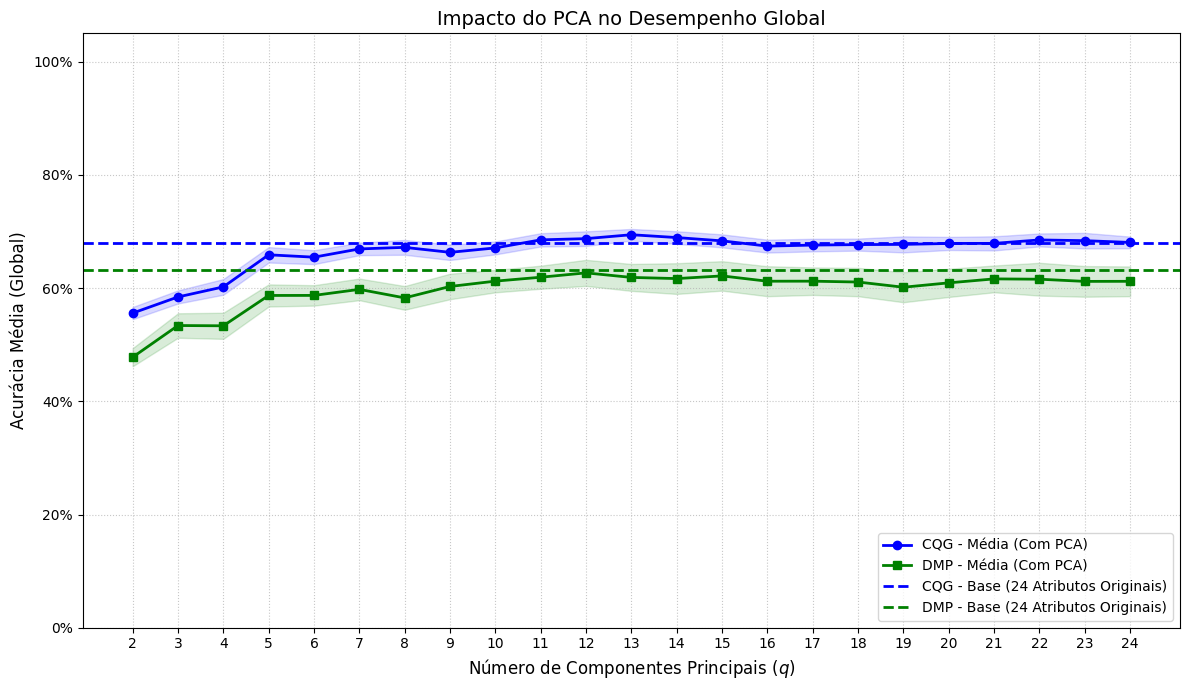

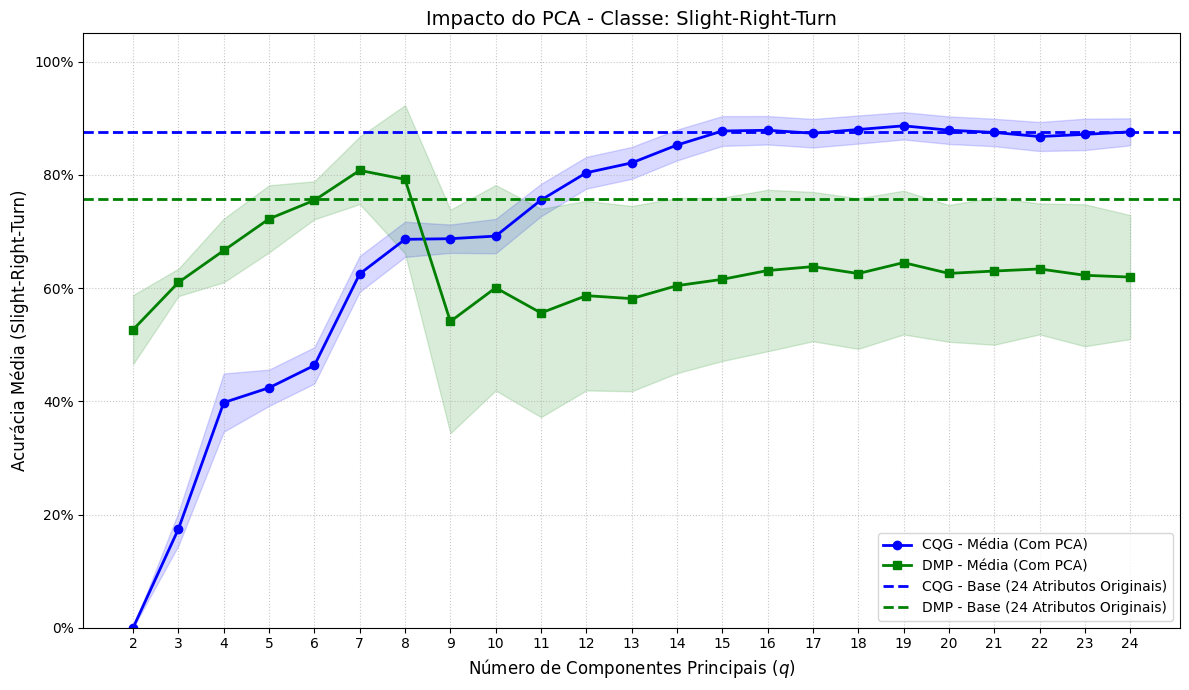

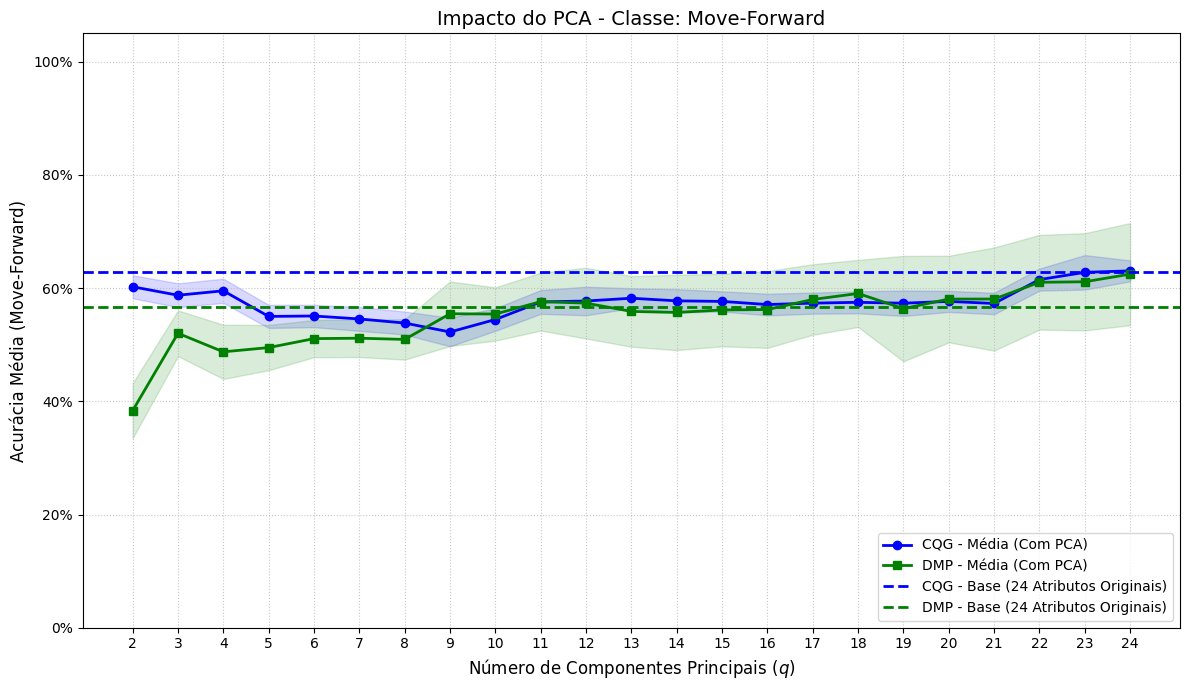

In [35]:
if __name__ == "__main__":
    # 1. Obter os dados
    # X, y, classes = carregar_dados(caminho)
    
    # 2. Rodar tudo e gerar as tabelas de Markdown (isso retorna os históricos)
    # resultados = rodar_experimentos_e_gerar_tabela_unica(X, y, classes, nr_rodadas=100)
    
    # 3. Gerar gráficos chamando a nova função:
    
    # Gráfico 1: Acurácia Global
    plotar_desempenho_pca(resultados, classe_alvo='Global')
    
    # Gráfico 2: Desempenho específico de uma classe que apresentou anomalia
    plotar_desempenho_pca(resultados, classe_alvo='Slight-Right-Turn')
    
    # Gráfico 3: Outra classe do seu conjunto de dados
    plotar_desempenho_pca(resultados, classe_alvo='Move-Forward')

## Questão 02

Aplicar PCA ao conjunto original de 24 sensores. Pede-se:

2.1. Determinar o número de componenets (q) adequado para o problema, ou seja, que promova uma redução de dimensão dos vetores de atributo sem piorar o desempenho dos classificadores implementados. Mostre o gráfico da variância explicada VE(q).

2.2. Repetir o experimento so Subitem 1.3. para os dados transformados por PCA, preenchendo uma tabela de resultados similar. Comente os resultados obtidos.

**OBS.: A implementação das tarefas pedidas nas Questões 1 e 2 é feita simultaneamente, na verdade. Enquano um classificador é testado sem PCA, já se pode testa-lo também após aplicação de PCA. Apenas a apresentação dos resultados é que é separada em duas questões para facilitar melhoro entendimento do efeito da aplicação de PCA**

---
¹ Este classificador é construído aplicando-se o algoritmo de K-médias aos dados de cada classe em separado. Cada classe terá seu número de protótipos, sendo que estes herdam o rótulo da classe a qual pertencem. Durante o teste, funciona como classificador distância mínima ao centroide, onde deve-se encontrar o protótipo da classe mais próxima. Para mais detalhes, vide slides do assunto "Introdução à Clusterização - Métodos Particionais"

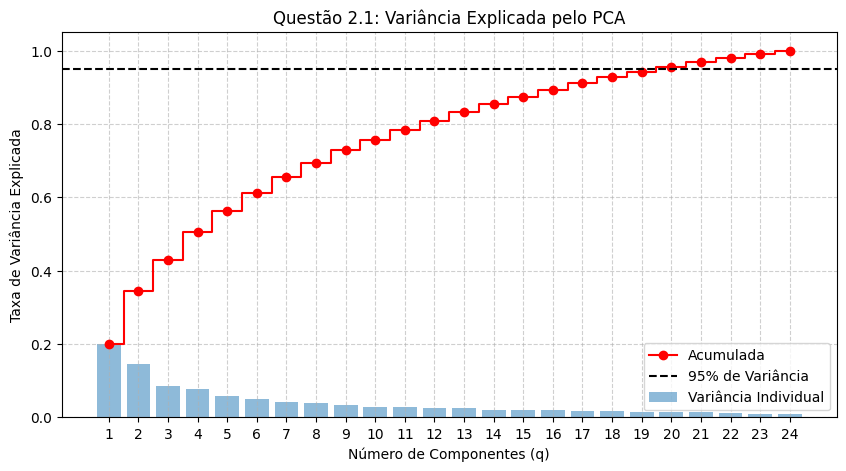

In [91]:
pca_full = PCA(n_components=None)
pca_full.fit(X)

var_ratio = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_ratio)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, label='Variância Individual')
plt.step(range(1, len(var_acumulada) + 1), var_acumulada, where='mid', color='red', marker='o', label='Acumulada')
plt.ylabel('Taxa de Variância Explicada')
plt.xlabel('Número de Componentes (q)')
plt.title('Questão 2.1: Variância Explicada pelo PCA')
plt.xticks(range(1, len(var_ratio) + 1))
plt.axhline(y=0.95, color='k', linestyle='--', label='95% de Variância')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()